In [1]:
import tensorflow as tf
import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

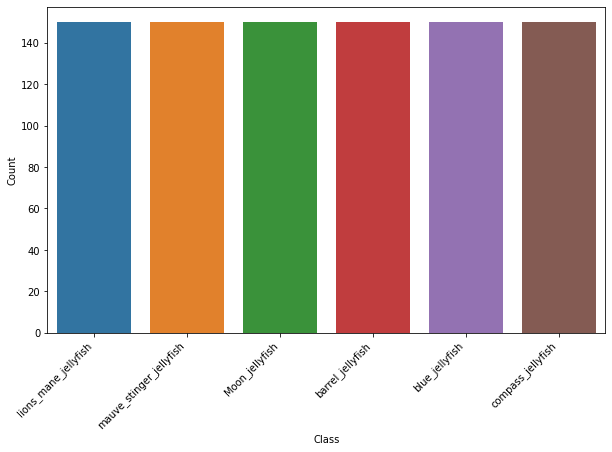

In [2]:
def load_data(data_directory):
    images = []
    labels = []
    classes = []
    label_encoder = LabelEncoder()

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        classes.append(class_name)

        for filename in os.listdir(class_path):
            filepath = os.path.join(class_path, filename)
            img = cv2.imread(filepath)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, (224, 224))
                img = img / 255.0
                images.append(img)
                labels.append(class_name)

    images = np.array(images)
    labels = label_encoder.fit_transform(labels) 

    return images, labels, classes

# Update the path to your dataset
data_directory = os.getenv('HOME')+'/aiffel/jellyfish/Train_Test_Valid/Train'
images, labels, classes = load_data(data_directory)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=[classes[label] for label in labels])  
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
classes = np.unique(classes)

In [3]:

# Sequential 모델 생성
model = Sequential()

# 첫 번째 합성곱 층 (입력 이미지 크기: 224x224, 3개의 컬러 채널)
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))

# 두 번째 합성곱 층
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))

# 최대 풀링 층 (크기 2x2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# 드롭아웃 층 (25%의 뉴런을 드롭아웃)
model.add(Dropout(0.25))

# 세 번째 합성곱 층
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

# 두 번째 최대 풀링 층
model.add(MaxPooling2D(pool_size=(2, 2)))

# 두 번째 드롭아웃 층 (25%의 뉴런을 드롭아웃)
model.add(Dropout(0.25))

# 이미지를 일렬로 펼치는 층
model.add(Flatten())

# 첫 번째 밀집 층 (뉴런 수: 128)
model.add(Dense(128))
model.add(Activation('relu'))

# 두 번째 밀집 층 (뉴런 수: 32)
model.add(Dense(32))
model.add(Activation('relu'))

# 출력 층 (6개의 클래스에 대한 소프트맥스 활성화 함수)
model.add(Dense(6, activation='softmax'))

# 모델 요약 출력
model.summary()

# 모델 컴파일 (Adam 옵티마이저, 희소 카테고리 크로스엔트로피 손실 함수, 정확도 메트릭스)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 이미지 데이터 증강 생성기 생성
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
)

# 검증을 위한 이미지 데이터 증강 생성기 생성
datagen1 = ImageDataGenerator()

# 훈련 데이터 및 레이블을 사용하여 배치 생성기 생성
train_generator = datagen.flow(X_train, y_train, batch_size=20)

# 검증 데이터 및 레이블을 사용하여 배치 생성기 생성
val_generator = datagen1.flow(X_test, y_test, batch_size=20)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      1

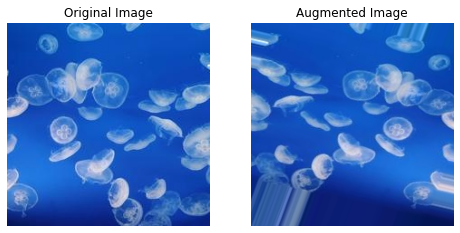

In [4]:
# 데이터 증강 전후비교

index = np.random.randint(0, len(X_train))

# 기존 이미지
original_image = (X_train[index]*255).astype(np.uint8)
original_image = original_image.astype(np.uint8)

# 증강 이미지
original_image = np.expand_dims(original_image, axis=0)

# iterator 생성
iterator = datagen.flow(original_image, batch_size=1)

# 증강이미지 생성
augmented_images = (iterator.next()).astype(np.uint8)

# 시각화
plt.figure(figsize=(8, 4))

# Original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image[0])
plt.axis('off')

# Augmented image
plt.subplot(1, 2, 2)
plt.title('Augmented Image')
plt.imshow(augmented_images[0] ,vmax = 1., vmin = 0)
plt.axis('off')

plt.show()

In [5]:
history = model.fit(train_generator, epochs=100, validation_data=val_generator)

Epoch 1/100
36/36 [==============================] - 11s 202ms/step - loss: 2.6124 - accuracy: 0.1597 - val_loss: 1.7796 - val_accuracy: 0.1889
Epoch 2/100
36/36 [==============================] - 7s 206ms/step - loss: 1.7404 - accuracy: 0.2417 - val_loss: 1.7680 - val_accuracy: 0.2889
Epoch 3/100
36/36 [==============================] - 7s 204ms/step - loss: 1.6219 - accuracy: 0.2958 - val_loss: 1.6791 - val_accuracy: 0.2611
Epoch 4/100
36/36 [==============================] - 7s 204ms/step - loss: 1.5375 - accuracy: 0.3625 - val_loss: 1.6307 - val_accuracy: 0.3000
Epoch 5/100
36/36 [==============================] - 7s 206ms/step - loss: 1.4306 - accuracy: 0.4111 - val_loss: 1.5407 - val_accuracy: 0.3889
Epoch 6/100
36/36 [==============================] - 7s 202ms/step - loss: 1.3025 - accuracy: 0.4722 - val_loss: 1.4297 - val_accuracy: 0.3778
Epoch 7/100
36/36 [==============================] - 7s 206ms/step - loss: 1.2289 - accuracy: 0.5278 - val_loss: 1.3991 - val_accuracy: 0.444

In [6]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Find the epoch with the highest validation accuracy
best_epoch = val_accuracy.index(max(val_accuracy)) + 1  # Add 1 because epochs are 1-indexed

print(f"Best Accuracy: {accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")
print(f"Best Validation Accuracy: {val_accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")

Best Accuracy: 0.8958 at Epoch 87
Best Validation Accuracy: 0.8944 at Epoch 87


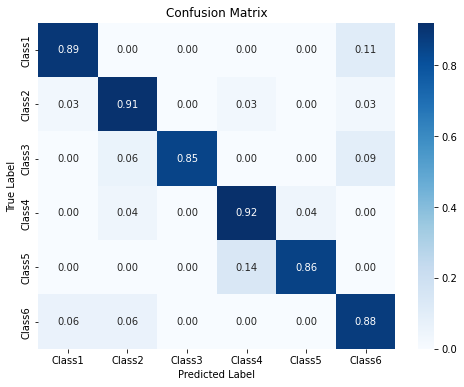

In [7]:
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true = y_test

conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Calculate class weights to account for imbalanced classes (optional)
weights = class_weight.compute_sample_weight('balanced', y_true)

# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Get class names from your data
classes = ["Class1", "Class2", "Class3", "Class4", "Class5", "Class6"]  # Replace with your actual class names

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

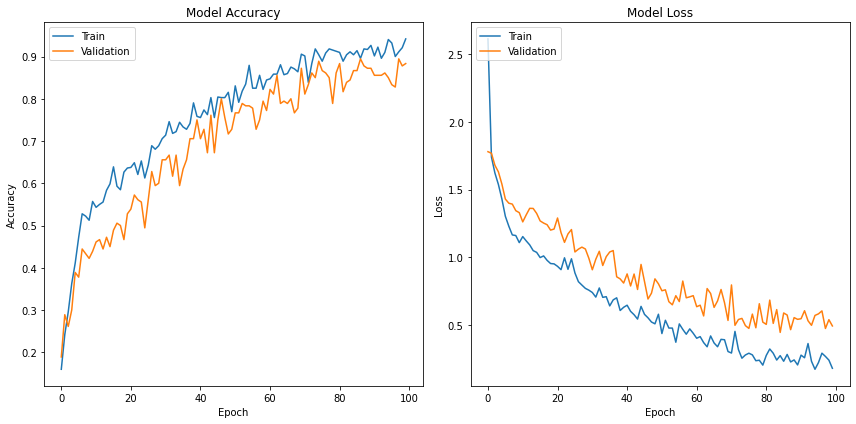

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()